In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from scipy.stats import f_oneway
import random
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

22/10/05 21:14:27 WARN Utils: Your hostname, DESKTOP-LNDD2A2 resolves to a loopback address: 127.0.1.1; using 172.28.37.254 instead (on interface eth0)
22/10/05 21:14:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/05 21:14:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/05 21:14:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Model 2: Profit per merchant per month

In [2]:
finaldf = spark.read.parquet("../data/curated/finaldf.parquet/")
finaldf.limit(5)

order_datetime,merchant_abn,user_id,postcode,consumer_id,dollar_value,order_id,state,gender,company_name,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income,consumer_fraud_%,merchant_fraud_%
2021-08-21,80682333501,3146,5651,604753,0.3672339667473312,2a59c978-f760-42d...,SA,Male,Orci Corp.,florists supplies...,4.88,b,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1
2021-08-19,99478391356,3146,5651,604753,3035.1695642706595,82e100bc-25c2-4e3...,SA,Male,Orci Quis Foundation,"equipment, tool, ...",1.52,c,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1
2021-08-19,86578477987,3146,5651,604753,61.05946896765003,9e3c8e62-9e8e-4e8...,SA,Male,Leo In Consulting,"watch, clock, and...",6.43,a,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1
2021-08-14,32361057556,3146,5651,604753,155.3456409871304,e4ff9499-e96d-4e6...,SA,Male,Orci In Consequat...,"gift, card, novel...",6.61,a,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1
2021-08-16,20445424481,3146,5651,604753,57.66971365811276,4a36f2ed-7bcc-43d...,SA,Male,Amet Industries,digital goods: bo...,6.29,a,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1


Extract the year and month from the order datetime into a seperate column, we will use these to both group the dataset and create a new feature int_month. We also create a feature profit, which is simply the dollar value multiplied by take rate for each individual transaction.

In [3]:
modeldf = finaldf.withColumn("year", date_format(col("order_datetime"), "yyyy").cast("long"))
modeldf = modeldf.withColumn("month", date_format(col("order_datetime"), "MM").cast("long"))
modeldf = modeldf.withColumn('profit', round(finaldf.dollar_value * (finaldf.take_rate / 100), 2))

for field in ("postcode","take_rate"):
    modeldf = modeldf.withColumn(
        field,
        col(field).cast('double')
    )

modeldf = modeldf.drop("order_datetime","order_id","company_name","consumer_fraud_%","merchant_fraud_%")

modeldf.limit(5)

merchant_abn,user_id,postcode,consumer_id,dollar_value,state,gender,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income,year,month,profit
80682333501,3146,5651.0,604753,0.3672339667473312,SA,Male,florists supplies...,4.88,b,2172,275,278,304,692,623,1308,47,37685,43540,2021,8,0.02
99478391356,3146,5651.0,604753,3035.1695642706595,SA,Male,"equipment, tool, ...",1.52,c,2172,275,278,304,692,623,1308,47,37685,43540,2021,8,46.13
86578477987,3146,5651.0,604753,61.05946896765003,SA,Male,"watch, clock, and...",6.43,a,2172,275,278,304,692,623,1308,47,37685,43540,2021,8,3.93
32361057556,3146,5651.0,604753,155.3456409871304,SA,Male,"gift, card, novel...",6.61,a,2172,275,278,304,692,623,1308,47,37685,43540,2021,8,10.27
20445424481,3146,5651.0,604753,57.66971365811276,SA,Male,digital goods: bo...,6.29,a,2172,275,278,304,692,623,1308,47,37685,43540,2021,8,3.63


In [4]:
modeldf = modeldf.groupBy("year","month","merchant_abn").agg(
    round(sum("profit"),2).alias("monthly_profit"),
)

In [5]:
MONTHS = 12
modeldf = modeldf.withColumn('int_month', MONTHS*(modeldf['year'] - 2021) + (modeldf['month'] - 1))
modeldf = modeldf.drop('year', 'month')
modeldf

merchant_abn,monthly_profit,int_month
50315283629,7611.69,21
40279146273,3666.26,20
60956456424,17330.74,16
10323485998,3845.55,20
94472466107,4043.85,16
77338620996,10072.1,16
41974958954,2564.23,6
74019238521,1415.73,10
80893432676,100.2,8
44210076869,552.1,3


If any of the valid merchant_abns from the final dataset do not have any transactions listed in the dataset, we will need to manually add a row stating this month had 0 monthly revenue.

In [6]:
merchant_abns = finaldf.select('merchant_abn').distinct().toPandas()['merchant_abn']

records = []
for m in merchant_abns:
    for int_month in range(1, 22):
        records.append([m, 0, int_month])
        
defaultdf = spark.createDataFrame(records, 
                                  schema=['merchant_abn', 'monthly_profit_0', 'int_month'])

# We first starts with all abns and months having 0 transactions, and overwrite the values that are present in modeldf.
modeldf = defaultdf.join(modeldf, on=['merchant_abn', 'int_month'], how='left')
modeldf = modeldf.drop('monthly_profit_0')
modeldf = modeldf.na.fill(value=0,subset=["monthly_profit"])

In [7]:
modeldf.sort('merchant_abn', 'int_month')

merchant_abn,int_month,monthly_profit
10023283211,1,1.26
10023283211,2,42.36
10023283211,3,45.01
10023283211,4,47.9
10023283211,5,45.3
10023283211,6,47.19
10023283211,7,49.2
10023283211,8,50.78
10023283211,9,60.3
10023283211,10,67.36


To determine the number of lags that are used, we build autocorrelation plots to determine the correlation between lags of the  monthly transactions feature. Note that these plots need to be created for an individual merchant, hence the code below chooses 5 random merchants (can uncomment the setting of the seed for this to becompletely randomised), and builds autocorrelation plots.

In [8]:
df = modeldf.toPandas()

In [9]:
one_hot = pd.get_dummies(df['merchant_abn'])
df = df.join(one_hot)
df 

,merchant_abn,int_month,monthly_profit,10023283211,10142254217,10165489824,10187291046,10192359162,10206519221,10255988167,...,99803748393,99807059634,99845294286,99861963809,99904689266,99938978285,99974311662,99976658299,99987905597,99990536339
0,38700038932,11,25783.11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,35344855546,19,192.27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,78916025936,13,10.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,60654402457,5,12.96,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,37470904997,14,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84373,72064300998,5,112.61,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84374,29623808496,21,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84375,47047735645,7,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84376,39700611505,15,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


26482181417


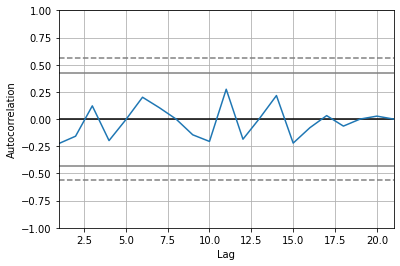

67797658023


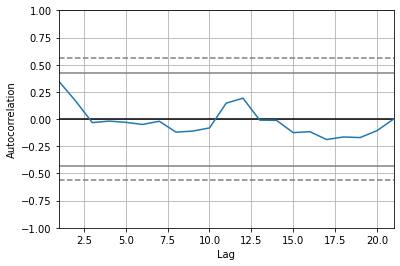

14480530534


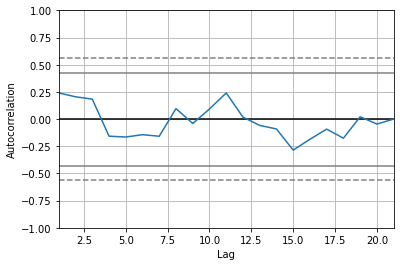

67979471799


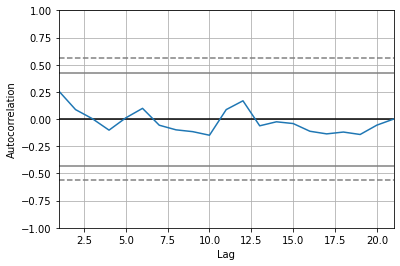

31686734877


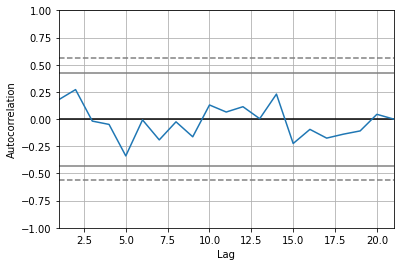

In [10]:
random.seed(4302022)

for i in range(5):
    random_merchant = random.sample(merchant_abns.tolist(), 1)[0]
    
    print(random_merchant)
    
    filtereddf = df[df[random_merchant] == 1][['int_month', 'monthly_profit']]
    filtereddf = filtereddf.sort_values('int_month')
    filtereddf = filtereddf['monthly_profit']
    
    x = pd.plotting.autocorrelation_plot(filtereddf)
 
    x.plot()
 
    plt.show()


Just as we saw with predicting the number of transaction, for a large number of merchants lags are correlated roughly on average until about a lag length of 2, hence will keep the same here for additional consistency benefits.

Again, prepare the dataframe for model training:

In [11]:
indexer = StringIndexer(inputCol='merchant_abn', outputCol='merchant_abn_class')
indexer_fitted = indexer.fit(modeldf)
modeldf = indexer_fitted.transform(modeldf)
modeldf

merchant_abn,int_month,monthly_profit,merchant_abn_class
38700038932,11,25783.11,1327.0
35344855546,19,192.27,1181.0
78916025936,13,10.0,3108.0
60654402457,5,12.96,2279.0
37470904997,14,0.0,1270.0
61867784114,3,87.01,2323.0
46331355995,7,2134.4,1668.0
35927874515,2,2110.72,1214.0
57093429717,20,429.26,2145.0
14316652139,8,233.55,190.0


In [12]:
encoder = OneHotEncoder(inputCols=['merchant_abn_class'], outputCols=['merchant_abn_ohe'])
modeldf = encoder.fit(modeldf).transform(modeldf)
modeldf

merchant_abn,int_month,monthly_profit,merchant_abn_class,merchant_abn_ohe
38700038932,11,25783.11,1327.0,"(4017,[1327],[1.0])"
35344855546,19,192.27,1181.0,"(4017,[1181],[1.0])"
78916025936,13,10.0,3108.0,"(4017,[3108],[1.0])"
60654402457,5,12.96,2279.0,"(4017,[2279],[1.0])"
37470904997,14,0.0,1270.0,"(4017,[1270],[1.0])"
61867784114,3,87.01,2323.0,"(4017,[2323],[1.0])"
46331355995,7,2134.4,1668.0,"(4017,[1668],[1.0])"
35927874515,2,2110.72,1214.0,"(4017,[1214],[1.0])"
57093429717,20,429.26,2145.0,"(4017,[2145],[1.0])"
14316652139,8,233.55,190.0,"(4017,[190],[1.0])"


In [13]:
partition = Window.partitionBy("merchant_abn").orderBy("int_month")
modeldf = modeldf.withColumn('monthly_profit-1', lag('monthly_profit', 1).over(partition))
modeldf = modeldf.withColumn('monthly_profit-2', lag('monthly_profit', 2).over(partition))
modeldf.show(60)

+------------+---------+--------------+------------------+----------------+----------------+----------------+
|merchant_abn|int_month|monthly_profit|merchant_abn_class|merchant_abn_ohe|monthly_profit-1|monthly_profit-2|
+------------+---------+--------------+------------------+----------------+----------------+----------------+
| 10023283211|        1|          1.26|               0.0|(4017,[0],[1.0])|            null|            null|
| 10023283211|        2|         42.36|               0.0|(4017,[0],[1.0])|            1.26|            null|
| 10023283211|        3|         45.01|               0.0|(4017,[0],[1.0])|           42.36|            1.26|
| 10023283211|        4|          47.9|               0.0|(4017,[0],[1.0])|           45.01|           42.36|
| 10023283211|        5|          45.3|               0.0|(4017,[0],[1.0])|            47.9|           45.01|
| 10023283211|        6|         47.19|               0.0|(4017,[0],[1.0])|            45.3|            47.9|
| 10023283

In [14]:
modeldf = modeldf.na.drop()
modeldf.count()

76342

Now we build our time series regression model, with our testing data being the final 3 months of the dataset.

In [15]:
SPLIT_MONTH = 18

vecAssembler = VectorAssembler(inputCols=['merchant_abn_ohe', 'int_month', 
                                          'monthly_profit-1', 
                                          'monthly_profit-2'], 
                               outputCol='features')

train = modeldf.filter(col('int_month') <= SPLIT_MONTH)
test = modeldf.filter(col('int_month') > SPLIT_MONTH)

train = vecAssembler.transform(train)
test = vecAssembler.transform(test)
train

merchant_abn,int_month,monthly_profit,merchant_abn_class,merchant_abn_ohe,monthly_profit-1,monthly_profit-2,features
10023283211,3,45.01,0.0,"(4017,[0],[1.0])",42.36,1.26,"(4020,[0,4017,401..."
10023283211,4,47.9,0.0,"(4017,[0],[1.0])",45.01,42.36,"(4020,[0,4017,401..."
10023283211,5,45.3,0.0,"(4017,[0],[1.0])",47.9,45.01,"(4020,[0,4017,401..."
10023283211,6,47.19,0.0,"(4017,[0],[1.0])",45.3,47.9,"(4020,[0,4017,401..."
10023283211,7,49.2,0.0,"(4017,[0],[1.0])",47.19,45.3,"(4020,[0,4017,401..."
10023283211,8,50.78,0.0,"(4017,[0],[1.0])",49.2,47.19,"(4020,[0,4017,401..."
10023283211,9,60.3,0.0,"(4017,[0],[1.0])",50.78,49.2,"(4020,[0,4017,401..."
10023283211,10,67.36,0.0,"(4017,[0],[1.0])",60.3,50.78,"(4020,[0,4017,401..."
10023283211,11,67.22,0.0,"(4017,[0],[1.0])",67.36,60.3,"(4020,[0,4017,401..."
10023283211,12,43.1,0.0,"(4017,[0],[1.0])",67.22,67.36,"(4020,[0,4017,401..."


In [16]:
lr = LinearRegression(featuresCol='features', labelCol='monthly_profit')
lrModel = lr.fit(train)

22/10/05 21:19:38 WARN Instrumentation: [df58fdca] regParam is zero, which might cause numerical instability and overfitting.


22/10/05 21:19:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/05 21:19:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/10/05 21:19:44 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [17]:
predictions = lrModel.transform(test)
predictions

merchant_abn,int_month,monthly_profit,merchant_abn_class,merchant_abn_ohe,monthly_profit-1,monthly_profit-2,features,prediction
10023283211,19,59.96,0.0,"(4017,[0],[1.0])",61.68,54.1,"(4020,[0,4017,401...",132.4725961369549
10023283211,20,70.14,0.0,"(4017,[0],[1.0])",59.96,61.68,"(4020,[0,4017,401...",139.88463951352685
10023283211,21,61.56,0.0,"(4017,[0],[1.0])",70.14,59.96,"(4020,[0,4017,401...",154.2695878543691
10142254217,19,235.46,1.0,"(4017,[1],[1.0])",233.71,176.81,"(4020,[1,4017,401...",300.96889548917306
10142254217,20,230.3,1.0,"(4017,[1],[1.0])",235.46,233.71,"(4020,[1,4017,401...",307.7675029050876
10142254217,21,297.41,1.0,"(4017,[1],[1.0])",230.3,235.46,"(4020,[1,4017,401...",313.59715624590496
10165489824,19,178.2,2.0,"(4017,[2],[1.0])",0.0,682.77,"(4020,[2,4017,401...",58.89954354922885
10165489824,20,221.73,2.0,"(4017,[2],[1.0])",178.2,0.0,"(4020,[2,4017,401...",199.7009395975776
10165489824,21,0.0,2.0,"(4017,[2],[1.0])",221.73,178.2,"(4020,[2,4017,401...",223.14981074556374
10187291046,19,51.9,3.0,"(4017,[3],[1.0])",51.14,77.09,"(4020,[3,4017,401...",126.84339927657298


15457638036


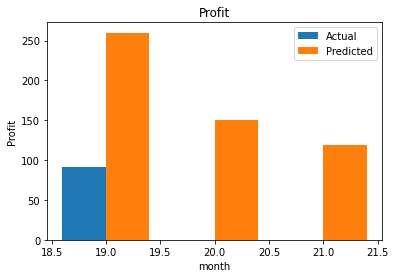

76351454594


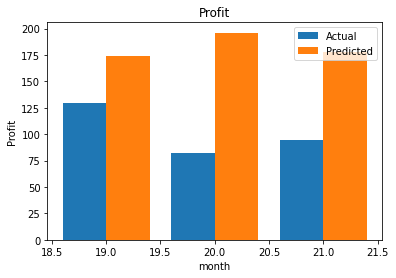

47879799074


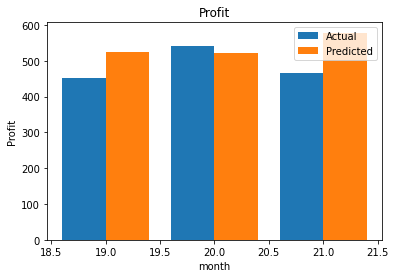

33064796871


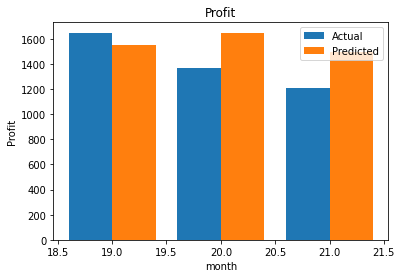

82081024598


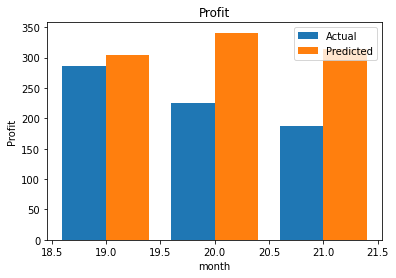

In [18]:
#random.seed(4302023)

dfp = predictions.toPandas()
X = [19, 20, 21]

for i in range(5):
    random_merchant = random.sample(merchant_abns.tolist(), 1)[0]
    print(random_merchant)
    X_axis = np.arange(19, 22)
    plt.bar(X_axis - 0.2, dfp[dfp['merchant_abn']==random_merchant]["monthly_profit"], 0.4, label = 'Actual')
    plt.bar(X_axis + 0.2, dfp[dfp['merchant_abn']==random_merchant]["prediction"], 0.4, label = 'Predicted')
    plt.legend()
    plt.xlabel('month')
    plt.ylabel('Profit')
    plt.title('Profit')
    plt.show()

# Simulation

Build up predictions until we reach 2023. Expect total run time of the following code to take several minutes.

In [19]:
pdf = predictions.select('merchant_abn', 'int_month', 'prediction', 'merchant_abn_ohe').toPandas()
pdf

,merchant_abn,int_month,prediction,merchant_abn_ohe
0,10023283211,19,132.472596,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,10023283211,20,139.884640,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,10023283211,21,154.269588,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,10142254217,19,300.968895,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,10142254217,20,307.767503,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
12049,99987905597,20,235.893626,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12050,99987905597,21,380.367826,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12051,99990536339,19,76.736766,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12052,99990536339,20,85.327298,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [20]:
records = []
for int_month in range(22, 36):
    merchant_data = []
    for m in merchant_abns:
        merchant_abn_ohe = pdf.loc[(pdf['merchant_abn']==m) & (pdf['int_month']==21), 'merchant_abn_ohe'].values[0]
        merchant_data.append([m, merchant_abn_ohe, int_month, 
                              float(pdf.loc[(pdf['merchant_abn']==m) & 
                                            (pdf['int_month']==(int_month-2)), 'prediction'].values[0]),
                              float(pdf.loc[(pdf['merchant_abn']==m) & 
                                            (pdf['int_month']==(int_month-1)), 'prediction'].values[0])])
        
    predictiondf = spark.createDataFrame(merchant_data, 
                                         schema=['merchant_abn', 'merchant_abn_ohe', 'int_month', 'monthly_profit-1', 
                                                 'monthly_profit-2'])
    predictiondf = vecAssembler.transform(predictiondf)
    predictiondf = lrModel.transform(predictiondf)
    pdf = pd.concat([pdf, predictiondf.select('merchant_abn', 'int_month', 'prediction', 'merchant_abn_ohe').toPandas()])
    
    if int_month >= 24:
        for m in merchant_abns:
            records.append([2021 + (int_month//12), (int_month%12) + 1, m, 
                            float(pdf.loc[(pdf['merchant_abn']==m) & 
                                          (pdf['int_month']==(int_month)), 'prediction'].values[0])])

In [21]:
future_profit_sdf = spark.createDataFrame(records, schema=['year', 'month', 'merchant_abn', 'total_profit'])

future_profit_sdf.write.mode("overwrite").parquet("../data/curated/futureprofit.parquet/")

----------------------------------------                                        
Exception happened during processing of request from ('127.0.0.1', 33682)
Traceback (most recent call last):
  File "/usr/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.8/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/jbretherton/.local/lib/python3.8/site-packages/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/home/jbretherton/.local/lib/python3.8/site-packages/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/home/jbretherton/.local/lib/python3.8/site-packages/pyspark/accumulators.py",